In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
pd.set_option('display.max_row',40)
pd.set_option('display.max_column',100) 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
df2 = pd.read_csv("oasis_longitudinal.csv")
df2.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


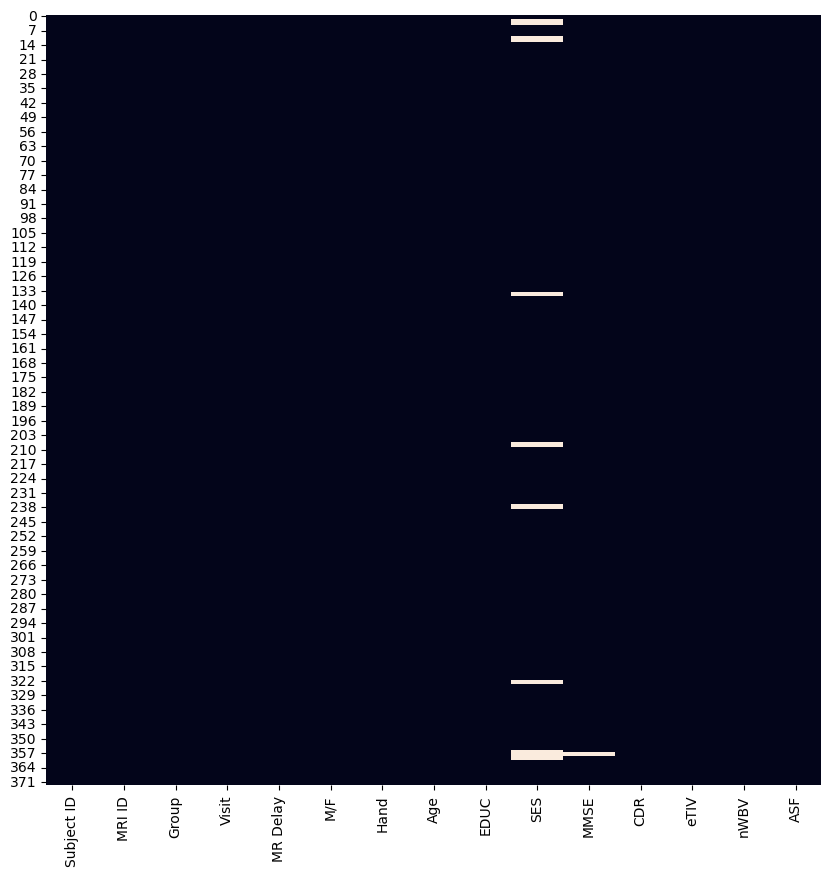

In [4]:
plt.figure(figsize=(10,10))
sns.heatmap(df2.isna(),cbar=False)
plt.show()

In [22]:
# drop the handiness variable
df2.drop(['Hand'],axis=1,inplace=True)
df2.drop(['Visit'],axis=1,inplace=True)

KeyError: "['Hand'] not found in axis"

In [23]:
# select from df only the columns with numerical values
df_num = df2.select_dtypes(exclude="object")
# create a new column called Group, where 1 is for the patients with AD and 0 for the patients without AD
df_num['Group'] = df2['Group'].apply(lambda x: 1 if x == 'Demented' else 0)
corr = df_num.corr(method='pearson').abs()

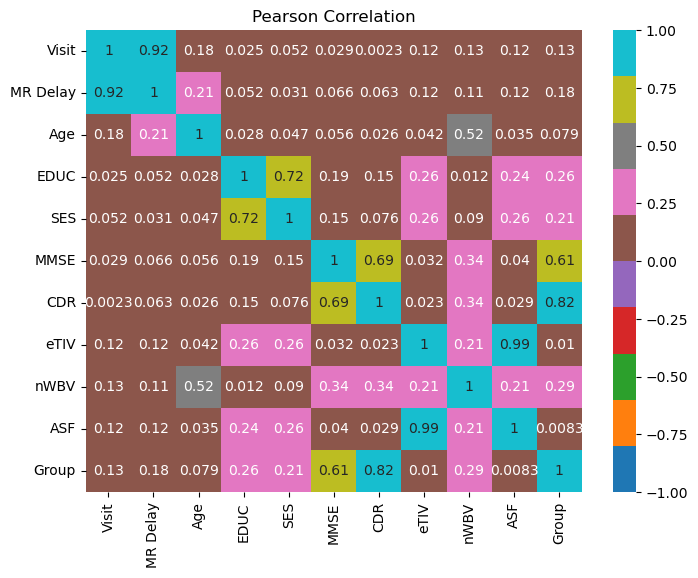

In [24]:
#finding the correlation relationship between all numberical variables
fig = plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='tab10', vmin=-1, vmax=+1)
plt.title('Pearson Correlation')
plt.show()

In [10]:
#Imputing missing values for KNNImputer
from sklearn.impute import KNNImputer
# create an instance of KNNImputer
inputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
# Input and print a report of what has been inputed
df = pd.DataFrame(inputer.fit_transform(df_num),columns=df_num.columns)
df.head()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Group
0,1.0,0.0,87.0,14.0,2.0,27.0,0.0,1987.0,0.696,0.883,0.0
1,2.0,457.0,88.0,14.0,2.0,30.0,0.0,2004.0,0.681,0.876,0.0
2,1.0,0.0,75.0,12.0,1.8,23.0,0.5,1678.0,0.736,1.046,1.0
3,2.0,560.0,76.0,12.0,1.6,28.0,0.5,1738.0,0.713,1.010,1.0
4,3.0,1895.0,80.0,12.0,2.6,22.0,0.5,1698.0,0.701,1.034,1.0


IndexError: index 2 is out of bounds for axis 0 with size 2

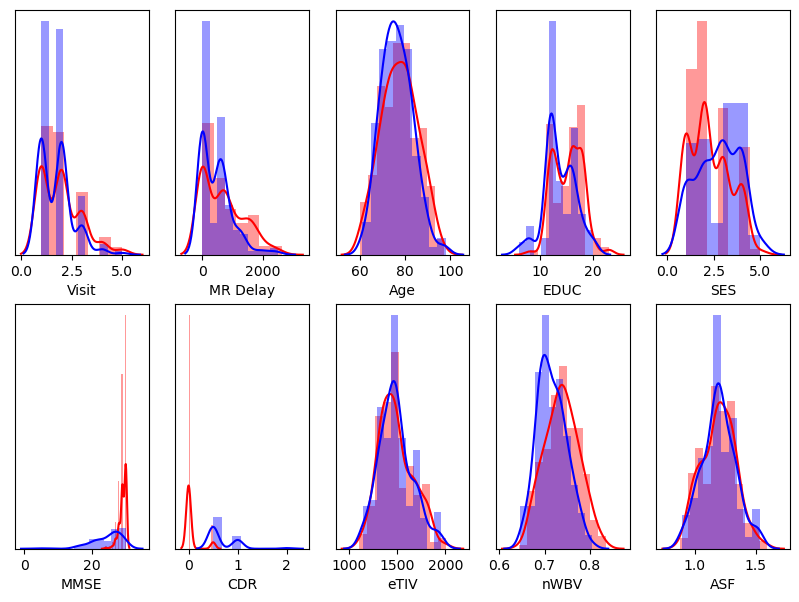

In [11]:
# visualizing the distribution of each independent variable
fig, axes = plt.subplots(2,5,figsize=(10,7))

for idx,col in enumerate(df.select_dtypes(include=['float64','int64'])):
    sns.distplot(df[df["Group"]==0][col],label='No AD',color='red',ax=axes[idx//5,idx%5])
    sns.distplot(df[df["Group"]==1][col],label='AD',color='blue',ax=axes[idx//5,idx%5])
    #hide y labels and values
    axes[idx//5,idx%5].set_yticks([])
    axes[idx//5,idx%5].set_ylabel('')
fig.tight_layout()
fig.legend(labels=['No AD',"_",'AD',"_"])
fig.show()

In [12]:
# Building the KNearest Neighbor Modeling
df.head()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Group
0,1.0,0.0,87.0,14.0,2.0,27.0,0.0,1987.0,0.696,0.883,0.0
1,2.0,457.0,88.0,14.0,2.0,30.0,0.0,2004.0,0.681,0.876,0.0
2,1.0,0.0,75.0,12.0,1.8,23.0,0.5,1678.0,0.736,1.046,1.0
3,2.0,560.0,76.0,12.0,1.6,28.0,0.5,1738.0,0.713,1.010,1.0
4,3.0,1895.0,80.0,12.0,2.6,22.0,0.5,1698.0,0.701,1.034,1.0


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop('Group',axis=1),df['Group'],test_size=0.2,random_state=42)
X, y = df.drop('Group',axis=1),df['Group']
print(y_train.value_counts())
print(y_test.value_counts())

0.0    184
1.0    114
Name: Group, dtype: int64
0.0    43
1.0    32
Name: Group, dtype: int64


In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

In [19]:
preprocessor = make_pipeline(StandardScaler())
KNNPipeline = make_pipeline(preprocessor,KNeighborsClassifier())

In [20]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import learning_curve, cross_val_score, GridSearchCV
from sklearn.metrics import RocCurveDisplay

def evaluation(model):
    model.fit(X_train, y_train)
    # calculating the probabilities
    y_pred_proba = model.predict_proba(X_test)

    # finding the predicted valued
    y_pred = np.argmax(y_pred_proba,axis=1)
    print('Accuracy = ', accuracy_score(y_test, y_pred))
    print('-')
    print(confusion_matrix(y_test,y_pred))
    print('-')
    print(classification_report(y_test,y_pred))
    print('-')
    RocCurveDisplay.from_predictions(
        y_test,
        y_pred,
        name=f"ROC",
        color="darkorange",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("One-vs-Rest ROC curve")
    plt.legend()
    plt.show()
    
    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4, scoring='accuracy', train_sizes=np.linspace(0.1,1,10))
    
    plt.figure(figsize=(8,6))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    plt.show()

Accuracy =  0.88
-
[[42  1]
 [ 8 24]]
-
              precision    recall  f1-score   support

         0.0       0.84      0.98      0.90        43
         1.0       0.96      0.75      0.84        32

    accuracy                           0.88        75
   macro avg       0.90      0.86      0.87        75
weighted avg       0.89      0.88      0.88        75

-


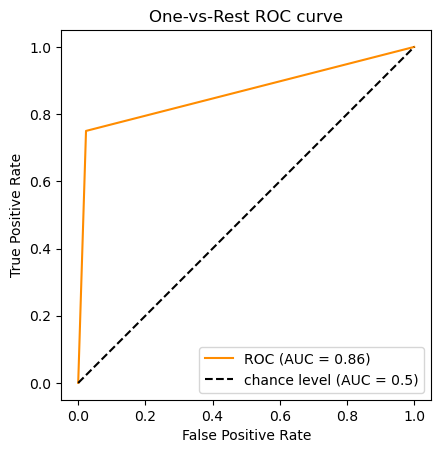

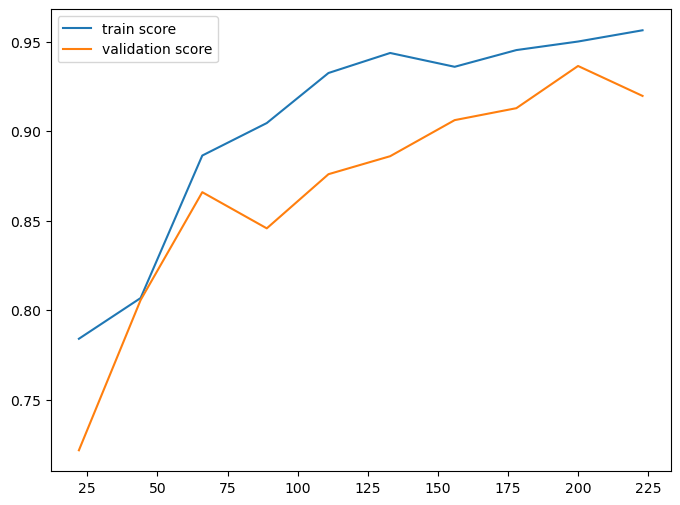

In [21]:
evaluation(KNNPipeline)